In [76]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from numpy import shape
import csv
import matplotlib.pyplot as plt

# My imports
import generative_models.load as load

In [77]:
# Load dataset
# Load dataset
filename_wind = 'generative_models/data/less_windy.csv'
#trX, trY, X_test, Y_test = load.load_wind(filename_wind, sample_size=2)

filename_solar = 'generative_models/data/solar.csv'
trX, X_test = load.load_solar(filename_solar, sample_size=2)

print("shape of training samples ", shape(trX))
print("Training data loaded")

maximum value of solar power 8.13
Solar data loaded
Total number of samples: 5840
Shape of training dataset: (4672, 576)
Shape of test datasaet: (1168, 576)
shape of training samples  (4672, 576)
Training data loaded


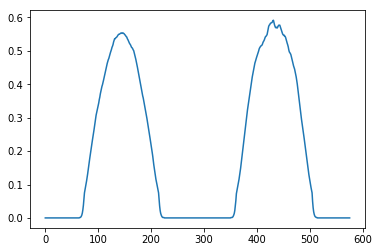

In [78]:
# Plot an example of training example
plt.plot(trX[0, :])

In [79]:
### model.py file ###

#The GANs model with Wasserstein distance along with helper functions

def batchnormalize(X, eps=1e-8, g=None, b=None):
    if X.get_shape().ndims == 4:
        mean = tf.reduce_mean(X, [0,1,2])
        std = tf.reduce_mean( tf.square(X-mean), [0,1,2] )
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,1,1,-1])
            b = tf.reshape(b, [1,1,1,-1])
            X = X*g + b

    elif X.get_shape().ndims == 2:
        mean = tf.reduce_mean(X, 0)
        std = tf.reduce_mean(tf.square(X-mean), 0)
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,-1])
            b = tf.reshape(b, [1,-1])
            X = X*g + b

    else:
        raise NotImplementedError

    return X

def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

# def bce(o, t):
#     o = tf.clip_by_value(o, 1e-7, 1. - 1e-7)
#     return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(o, t))


#model in DCGAN:
#discriminate, generate, samples_generator
class GAN():
    def __init__(
            self,
            batch_size=32,
            image_shape=[24,24,1],
            dim_z=100,
            dim_W1=1024,
            dim_W2=128,
            dim_W3=64,
            dim_channel=1,
            max_value = 16
            ):

        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_z = dim_z
        self.max_value = max_value

        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        self.gen_W1 = tf.Variable(tf.random_normal([dim_z, dim_W1], stddev=0.02), name='gen_W1')
        self.gen_W2 = tf.Variable(tf.random_normal([dim_W1, dim_W2*6*6], stddev=0.02), name='gen_W2')
        self.gen_W3 = tf.Variable(tf.random_normal([5, 5, dim_W3, dim_W2], stddev=0.02), name='gen_W3')
        self.gen_W4 = tf.Variable(tf.random_normal([5, 5, dim_channel, dim_W3], stddev=0.02), name='gen_W4')

        self.discrim_W1 = tf.Variable(tf.random_normal([5, 5, dim_channel, dim_W3], stddev=0.02), name='discrim_W1')
        self.discrim_W2 = tf.Variable(tf.random_normal([5, 5, dim_W3, dim_W2], stddev=0.02), name='discrim_W2')
        self.discrim_W3 = tf.Variable(tf.random_normal([dim_W2*6*6, dim_W1], stddev=0.02), name='discrim_W3')
        self.discrim_W4 = tf.Variable(tf.random_normal([dim_W1, 1], stddev=0.02), name='discrim_W4')

    def build_model(self):

        Z = tf.placeholder(tf.float32, [self.batch_size, self.dim_z])

        image_real = tf.placeholder(tf.float32, [self.batch_size] + self.image_shape)
        h4 = self.generator(Z)
        #image_gen comes from sigmoid output of generator
        image_gen = tf.nn.sigmoid(h4)

        raw_real2 = self.discriminate(image_real)
        #p_real = tf.nn.sigmoid(raw_real)
        p_real=tf.reduce_mean(raw_real2)

        raw_gen2 = self.discriminate(image_gen)
        #p_gen = tf.nn.sigmoid(raw_gen)
        p_gen = tf.reduce_mean(raw_gen2)

        discrim_cost = tf.reduce_sum(raw_real2) - tf.reduce_sum(raw_gen2)
        gen_cost = -tf.reduce_mean(raw_gen2)

        return Z, image_real, discrim_cost, gen_cost, p_real, p_gen


    def discriminate(self, image):
        print("Initializing the discriminator")
        h1 = lrelu( tf.nn.conv2d(image, self.discrim_W1, strides=[1,2,2,1],
                                 padding='SAME' ))
        print("h1 shape", h1.get_shape())

        h2 = lrelu(batchnormalize(tf.nn.conv2d(h1, self.discrim_W2, strides=[1,2,2,1], padding='SAME')) )
        print("h2 shape", h2.get_shape())

        h2 = tf.reshape(h2, [self.batch_size, -1]) #???
        discri = tf.matmul(h2, self.discrim_W3 )
        print("discri shape", discri.get_shape())

        h3 = lrelu(batchnormalize(discri))
        return h3


    def generator(self, Z):
        print("Initializing the generator")
        print("Input Z shape", Z.get_shape())

        h1 = tf.nn.relu(batchnormalize(tf.matmul(Z, self.gen_W1)))
        print("h1 shape", h1.get_shape())

        h2 = tf.nn.relu(batchnormalize(tf.matmul(h1, self.gen_W2)))
        print("h2 shape", h2.get_shape())
        h2 = tf.reshape(h2, [self.batch_size,6,6,self.dim_W2])
        print("h2 shape", h2.get_shape())

        output_shape_l3 = [self.batch_size,12,12,self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.gen_W3, output_shape=output_shape_l3, strides=[1,2,2,1])
        h3 = tf.nn.relu( batchnormalize(h3))
        print("h3 shape", h3.get_shape())

        output_shape_l4 = [self.batch_size,24,24,self.dim_channel]
        h4 = tf.nn.conv2d_transpose(h3, self.gen_W4, output_shape=output_shape_l4, strides=[1,2,2,1])
        return h4


    def samples_generator(self, batch_size):
        Z = tf.placeholder(tf.float32, [batch_size, self.dim_z])

        h1 = tf.nn.relu(batchnormalize(tf.matmul(Z, self.gen_W1)))

        h2 = tf.nn.relu(batchnormalize(tf.matmul(h1, self.gen_W2)))
        h2 = tf.reshape(h2, [batch_size,6,6,self.dim_W2])

        output_shape_l3 = [batch_size,12,12,self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.gen_W3, output_shape=output_shape_l3, strides=[1,2,2,1])
        h3 = tf.nn.relu( batchnormalize(h3) )

        output_shape_l4 = [batch_size,24,24,self.dim_channel]
        h4 = tf.nn.conv2d_transpose(h3, self.gen_W4, output_shape=output_shape_l4, strides=[1,2,2,1])
        x = tf.nn.sigmoid(h4)
        return Z, x

In [80]:
### Build model

# Parameters
batch_size = 32
image_shape = [24,24,1] # The shape for input data
dim_z = 100             # Input dimension for latent vector z
dim_W1 = 1024           # Units in first neuron layer
dim_W2 = 128            # Units in second neuron layer
dim_W3 = 64             # Units in third neuron layer
mu, sigma = 0, 0.1      # Parameters of input Gaussian
max_value = 16          # Maximum value in time series

visualize_dim=32
generated_dim=32

# Initialize model
gan = GAN(batch_size=batch_size,
                  image_shape=image_shape,
                  dim_z=dim_z,
                  dim_W1=dim_W1,
                  dim_W2=dim_W2,
                  dim_W3=dim_W3,
                  dim_channel=1,
                  max_value=max_value)
print("W_DCGAN model initialized\n")


#Z_tf,Y_tf: placeholder
#image_tf: image placeholder
#d_cost_tf, g_cost_tf: discriminator and generator cost
#p_real, p_gen: the output of discriminator to judge real/generated

Z_tf, image_tf, d_cost_tf, g_cost_tf, p_real, p_gen = gan.build_model()

W_DCGAN model initialized

Initializing the generator
Input Z shape (32, 100)
h1 shape (32, 1024)
h2 shape (32, 4608)
h2 shape (32, 6, 6, 128)
h3 shape (32, 12, 12, 64)
Initializing the discriminator
h1 shape (32, 12, 12, 64)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)
Initializing the discriminator
h1 shape (32, 12, 12, 64)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)


epoch0
iterations  0
Average P(real)= 0.32924896
Average P(gen)= 0.32094145
Discrim loss: 272.2207


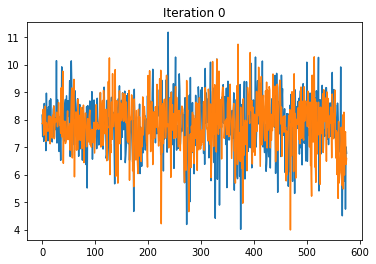

epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
iterations  1000
Average P(real)= 0.38021863
Average P(gen)= 0.3029312
Discrim loss: 2532.5547


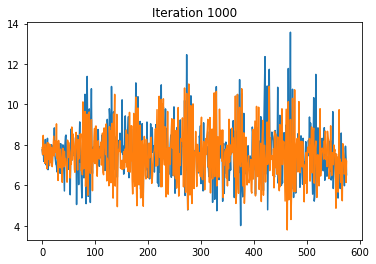

epoch7
epoch8
epoch9
epoch10
epoch11
epoch12
epoch13
iterations  2000
Average P(real)= 0.38643768
Average P(gen)= 0.32625607
Discrim loss: 1972.0312


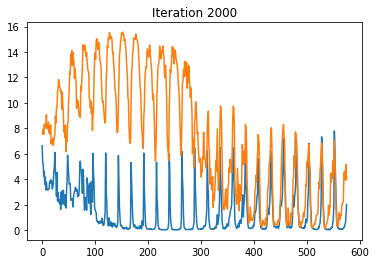

epoch14
epoch15
epoch16
epoch17
epoch18
epoch19
epoch20
iterations  3000
Average P(real)= 0.37233973
Average P(gen)= 0.28707796
Discrim loss: 2793.8574


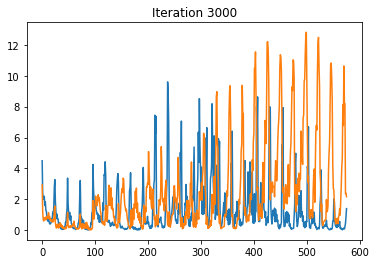

epoch21
epoch22
epoch23
epoch24
epoch25
epoch26
epoch27
iterations  4000
Average P(real)= 0.3805592
Average P(gen)= 0.30762976
Discrim loss: 2389.752


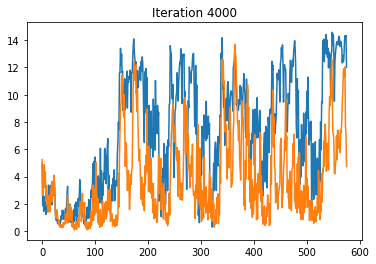

epoch28
epoch29
epoch30
epoch31
epoch32
epoch33
epoch34
iterations  5000
Average P(real)= 0.3823049
Average P(gen)= 0.3301713
Discrim loss: 1708.3145


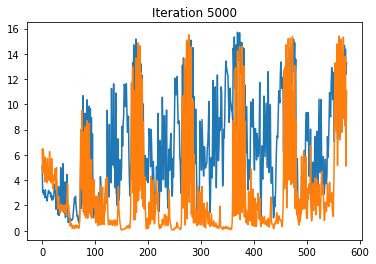

epoch35
epoch36
epoch37
epoch38
epoch39
epoch40
epoch41
iterations  6000
Average P(real)= 0.38650584
Average P(gen)= 0.30684918
Discrim loss: 2610.1895


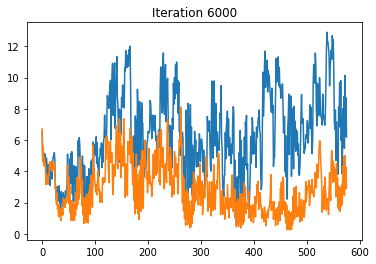

epoch42
epoch43
epoch44
epoch45
epoch46
epoch47
epoch48
iterations  7000
Average P(real)= 0.37382072
Average P(gen)= 0.29831666
Discrim loss: 2474.1172


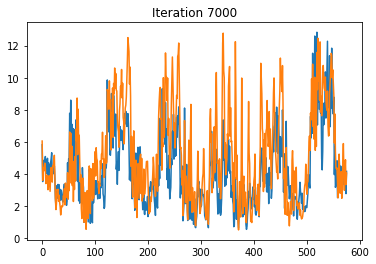

epoch49
epoch50
epoch51
epoch52
epoch53
epoch54
epoch55
iterations  8000
Average P(real)= 0.38761008
Average P(gen)= 0.28774828
Discrim loss: 3272.2715


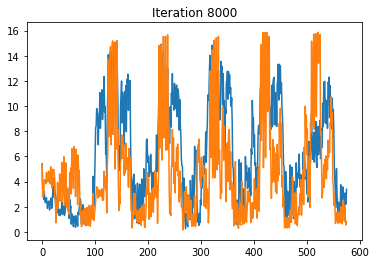

epoch56
epoch57
epoch58
epoch59
epoch60
epoch61
epoch62
iterations  9000
Average P(real)= 0.39459825
Average P(gen)= 0.29799402
Discrim loss: 3165.5273


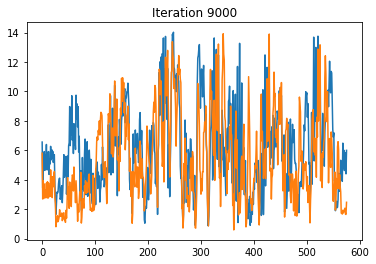

epoch63
epoch64
epoch65
epoch66
epoch67
epoch68
iterations  10000
Average P(real)= 0.38292158
Average P(gen)= 0.30273885
Discrim loss: 2627.4277


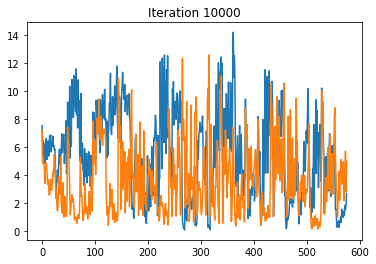

epoch69
epoch70
epoch71
epoch72
epoch73
epoch74
epoch75
iterations  11000
Average P(real)= 0.38124478
Average P(gen)= 0.32755172
Discrim loss: 1759.4141


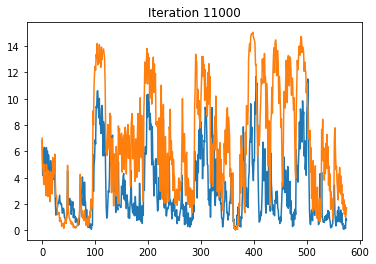

epoch76
epoch77
epoch78
epoch79
epoch80
epoch81
epoch82
iterations  12000
Average P(real)= 0.39331368
Average P(gen)= 0.31409267
Discrim loss: 2595.914


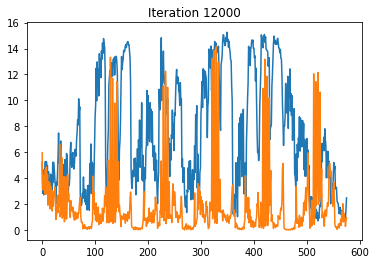

epoch83
epoch84
epoch85
epoch86
epoch87
epoch88
epoch89
iterations  13000
Average P(real)= 0.38638085
Average P(gen)= 0.325823
Discrim loss: 1984.3594


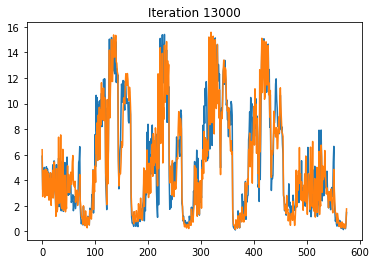

epoch90
epoch91
epoch92
epoch93
epoch94
epoch95
epoch96
iterations  14000
Average P(real)= 0.3818035
Average P(gen)= 0.32128596
Discrim loss: 1983.0391


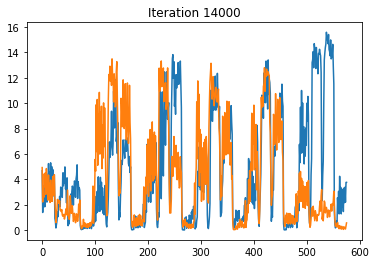

epoch97
epoch98
epoch99
Total number of iterations: 14500
P_real [0.32924896, 0.34336084, 0.355722, 0.3456538, 0.3490588, 0.35226646, 0.35679287, 0.33955762, 0.34431112, 0.36145675, 0.34455764, 0.3520043, 0.3516019, 0.35491985, 0.3435657, 0.3461226, 0.343312, 0.3657879, 0.35795683, 0.35110343, 0.33213675, 0.3505031, 0.355047, 0.36105442, 0.34534544, 0.35398114, 0.3532113, 0.35101599, 0.34407398, 0.35030556, 0.34641284, 0.36696935, 0.35028085, 0.3567454, 0.35479224, 0.35944667, 0.3523618, 0.357597, 0.3559878, 0.35448685, 0.3504799, 0.35486865, 0.36597973, 0.34746686, 0.362373, 0.3425934, 0.35934174, 0.352601, 0.35208726, 0.35076076, 0.3552313, 0.3490072, 0.35780132, 0.35194102, 0.3595636, 0.3612457, 0.35993046, 0.37315485, 0.3670432, 0.3494431, 0.35989642, 0.35829428, 0.34770626, 0.35984704, 0.35137445, 0.36057425, 0.35522118, 0.36287332, 0.3590446, 0.36591676, 0.36699012, 0.35038018, 0.35473272, 0.35721144, 0.35983777, 0.36527854, 0.35366443, 0.363868, 0.3603652, 0.35776943, 0.36240327

In [82]:
### train.py  file

# Training parameters
n_epochs = 100
learning_rate = 0.0002

# Folder to save generated images to
RUN = 1
folder_name = 'generative_models/runs/run' + str(RUN) + '/'
!rm -r $folder_name
!mkdir $folder_name

sess = tf.InteractiveSession()
saver = tf.train.Saver(max_to_keep=10)

discrim_vars = filter(lambda x: x.name.startswith('discrim'), tf.trainable_variables())
gen_vars = filter(lambda x: x.name.startswith('gen'), tf.trainable_variables())
discrim_vars = [i for i in discrim_vars]
gen_vars = [i for i in gen_vars]

train_op_discrim = (tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(-d_cost_tf, var_list=discrim_vars))
train_op_gen = (tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(g_cost_tf, var_list=gen_vars))

Z_tf_sample, image_tf_sample = gan.samples_generator(batch_size=visualize_dim)
tf.initialize_all_variables().run()

Zs = np.random.normal(mu, sigma, size=[gan.batch_size, gan.dim_z]).astype(np.float32)
iterations = 0
k = 4 #control the balance of training D and G

gen_loss_all=[]
P_real=[]
P_fake=[]
P_distri=[]
discrim_loss=[]


# Begin training
for epoch in range(n_epochs):
    print("epoch" + str(epoch))
    
    # Shuffle training data set
    index = np.arange(trX.shape[0])
    np.random.shuffle(index)
    trX = trX[index]

    for start, end in zip(
            range(0, trX.shape[0], gan.batch_size),
            range(gan.batch_size, trX.shape[0], gan.batch_size)
            ):

        Xs = trX[start:end].reshape([-1, 24, 24, 1])

        #use Gaussian distribution data to generate adversarial samples
        Zs = np.random.normal(mu, sigma, size=[gan.batch_size, gan.dim_z]).astype(np.float32)

        #for each iteration, generate g and d respectively, k=2
        if np.mod( iterations, k) == 0:
            _, gen_loss_val = sess.run(
                    [train_op_gen, g_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        image_tf: Xs
                        })
            discrim_loss_val, p_real_val, p_gen_val = sess.run([d_cost_tf,p_real,p_gen], feed_dict={Z_tf:Zs, image_tf:Xs})

        else:
            _, discrim_loss_val = sess.run(
                    [train_op_discrim, d_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        image_tf:Xs
                        })

            gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen],
                                                       feed_dict={Z_tf: Zs, image_tf: Xs})
        P_real.append(p_real_val.mean())
        P_fake.append(p_gen_val.mean())

        discrim_loss.append(discrim_loss_val)


        if np.mod(iterations, 1000) == 0:
            print("iterations ", iterations)
            print("Average P(real)=", p_real_val.mean())
            print("Average P(gen)=", p_gen_val.mean())
            print("Discrim loss:", discrim_loss_val)

            Z_np_sample = np.random.normal(mu, sigma, size=[gan.batch_size, gan.dim_z]).astype(np.float32)
            generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample})
            generated_samples = generated_samples.reshape([-1,576])
            generated_samples = generated_samples * gan.max_value
            csvfile = folder_name + f'samples_{iterations}.csv'
            with open(csvfile, 'w') as f:
                writer = csv.writer(f)
                writer.writerows(generated_samples)
                
            plt.figure()
            for sample in generated_samples[:2, :]:
                plt.plot(sample)
            plt.title(f'Iteration {iterations}')
            plt.show()

        iterations += 1

Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
generated_samples = sess.run(
    image_tf_sample,
    feed_dict={Z_tf_sample: Z_np_sample})
generated_samples = generated_samples.reshape([-1,576])
generated_samples = generated_samples * gan.max_value
csvfile = folder_name + 'sample1.csv'
with open(csvfile, 'w')  as f:
    writer = csv.writer(f)
    writer.writerows(generated_samples)
    
# Print total number of iterations
print(f'Total number of iterations: {iterations}')

#plot the loss and P_real as well as P_fake
print("P_real",P_real)
print("P_fake",P_fake)

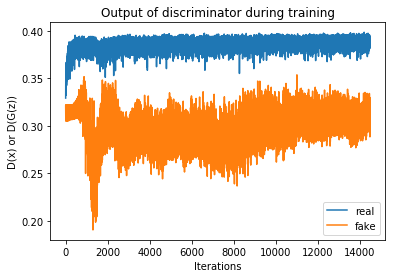

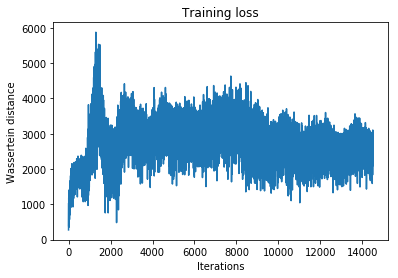

In [83]:
# Plot propobility curves
plt.plot(P_real,label="real")
plt.plot(P_fake,label="fake")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('D(x) or D(G(z))')
plt.title('Output of discriminator during training')
#plt.savefig('generative_models/figures/mode_collapse_D_solar')
plt.show()

plt.plot(discrim_loss)
plt.xlabel('Iterations')
plt.ylabel('Wassertein distance')
plt.title('Training loss')
#plt.savefig('generative_models/figures/mode_collapse_loss_solar')
plt.show()

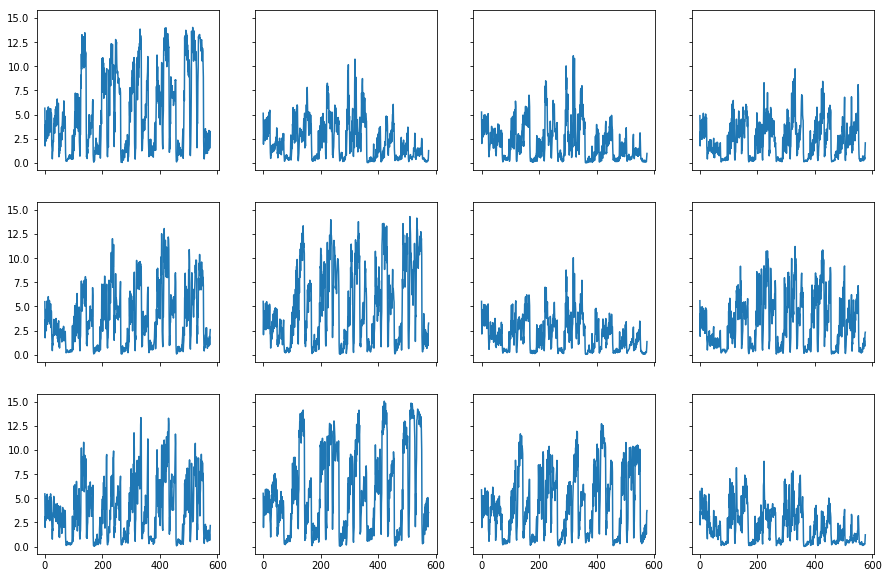

In [84]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 10))

for i in range(3):
    for j in range(4):
        Zs = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
        generated_samples = sess.run(
            image_tf_sample,
            feed_dict={Z_tf_sample: Zs})
        generated_samples = generated_samples.reshape([-1,576])
        generated_samples = generated_samples * gan.max_value

        ax = axes[i, j]
        ax.plot(generated_samples[0, :])
plt.savefig('generative_models/figures/mode_collapse_generated_examples.png', tight_layout=True)
plt.show()

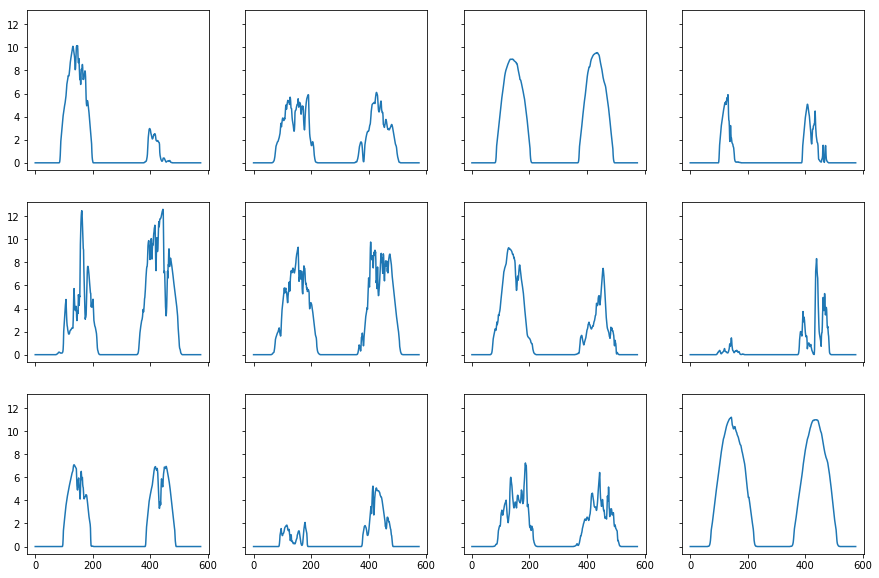

In [65]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 10))

for i in range(3):
    for j in range(4):
        examples = trX[np.random.randint(trX.shape[0])]
        examples = examples * gan.max_value

        ax = axes[i, j]
        ax.plot(examples)
#plt.savefig('generative_models/figures/solar_training_examples.png', tight_layout=True)
plt.show()

In [68]:
filename = 'generative_models/data/solar_data_2006/Actual_33.45_-117.65_2006_DPV_74MW_5_Min.csv'
df = pd.read_csv(filename)

# with open(filename, 'r') as f:
#     reader = csv.reader(f)
#     rows = [row for row in reader]
# rows = np.array(rows, dtype=float)

array([0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0], dtype=object)